In [1]:
%load_ext autoreload
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from os.path import expanduser
#from lib.definitions.classdefinitions import *
import lib.definitions.classdefinitions as classdef
import lib.filter as filter
import lib.sqlite_load as sq
import lib.util as util
import lib.plot as plot
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import prettyprinter as pp
import importlib

FLOW_LABELS = [0, 255, 65280, 983040, 1048575]

vantage_point: str = classdef.VantagePoint.sfo
#db_path = "/home/erlend/db-storage/large-data/" + classdef.Databases.nyc
db_path = "/home/erlend/db-storage/" + classdef.Databases.sfo

logging.basicConfig(level=logging.CRITICAL)
vp = classdef.VantagePoint()
home = expanduser("~")
# Test/small data:
db_dir = home + "/git/scripts/stats/sample-data/db/*.db"

print(f"Vantage point:\n{classdef.VPFullNames.sfo}")

Vantage point:
San Francisco, United States


# Evaluation

## Stats

In [3]:
test: bool = False
if test:
    db_path = home + "/git/scripts/stats/sample-data/db/db-ubuntu-fra1-0-2023-01-22T17_04_15Z.db"
    df: pd.DataFrame = sq.load_single(db_path)
else:
    df: pd.DataFrame = sq.load_single(db_path)
stats = util.create_stats(df)
pp.pprint(stats)

TracerouteStatistics(num_rows_total=155776, num_cycles=52834, num_cycle_rows=28529, num_loops=48093, num_loop_rows=24575, num_fl_changes=0, num_fl_change_rows=0, num_unique_asns_in_dataset=15642, num_invalid_rows=43552, n_traceroutes_to_the_same_destination_with_the_same_flow_label=2, num_vantage_points=8)


# Flow label persistence
### Does the flow label change in-transit?

In [4]:
import time

def count_rows_with_path_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return len(indices)

def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        for val in flow_labels:
            if src_fl != val:
                num_flow_label_changes += 1
    return num_flow_label_changes

def get_changed_flow_labels(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    changed_flow_labels = list()
    for row_idx in df.index:
        src_fl: int = int(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        flow_labels = [int(i) for i in flow_labels]
        for val in flow_labels:
            if src_fl != val:
                changed_flow_labels.append(val)
    return changed_flow_labels

def get_flow_label_change_router_ips(df: pd.DataFrame):
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    fl_change_hops = list()
    fl_change_router_asns = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        hop_ip_addresses: list = df["HOP_IP_ADDRESSES"].iloc[row_idx].split(" ")
        hop_numbers: list = df["HOP_NUMBERS"].iloc[row_idx].split(" ")
        hop_asns: list = df["HOP_ASNS"].iloc[row_idx].split(" ")
        for idx, val in enumerate(returned_flow_labels):
            if src_fl != val:
                if idx > 0:
                    if (int(hop_numbers[idx]) - 1) == int(hop_numbers[idx-1]):
                        fl_change_hops.append(hop_ip_addresses[idx-1])
                        fl_change_router_asns.append(hop_asns[idx-1])
    # If fl_change_hops is empty:
    if not fl_change_hops:
        return None
    return zip(fl_change_hops, fl_change_router_asns)

num_rows = get_num_rows(df)
num_flow_label_changes = count_flow_label_changes(df)
num_rows_with_flow_label_changes = count_rows_with_path_flow_label_changes(df)

print(f"Total number of rows: {num_rows}")
print(f"Total number of flow label changes: {num_flow_label_changes}")
print(f"Total number of rows with flow label changes: {num_rows_with_flow_label_changes}")

if num_rows_with_flow_label_changes > 0:
    changed_flow_labels = get_changed_flow_labels(df)
    df_changed_flow_labels = pd.Series(changed_flow_labels)
    changed_flow_labels_vc = df_changed_flow_labels.value_counts()
    print("value_counts:")
    print(changed_flow_labels_vc)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    changed_flow_labels_vc.plot.bar()

    router_ips = list()
    router_asns = list()
    for i in get_flow_label_change_router_ips(df):
        router_ips.append(i[0])
        router_asns.append(i[1])
    print(f"unique list of flow label change router IP addresses: {set(router_ips)}")
    df_router_ips = pd.Series(router_ips)
    router_ips_vc = df_router_ips.value_counts()
    print("router IPs value counts")
    print(router_ips_vc)
    print(f"length of unique list of flow label change router IP addresses: {len(set(router_ips))}")
    print(f"unique list of flow label change router ASNs: {set(router_asns)}")
    df_asns = pd.Series(router_asns)
    asns_vc = df_asns.value_counts()
    print("ASNs value counts")
    print(asns_vc)

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(asns_vc, labels=asns_vc.index, autopct='%1.1f%%', textprops={'fontsize': 20})

Total number of rows: 155776
Total number of flow label changes: 0
Total number of rows with flow label changes: 0


## Flow label stats

So let’s find:
- per vantage point:
  1. how often has it changed zero => non-zero  (that would be quite ok to do)
  2. how often has it non-zero => zero  (that would be totally forbidden!)
  3. how often has it changed non-zero => non-zero  (that would be an exception case, allowed as a defense against covert channels only)

All cases: we want to know how many routers did this (by investigating the traceroute response), and for cases 2 and 3, we definitely want to investigate further: where in the world were they?
What were the original flow label values? What are the output values  => BECAUSE this could be related to the size of the field (operating only on the lower 16 bit or something)

There will also be a class of “unknown” in your data, for when the router which changed the flow label didn’t answer.

## number of zero => non-zero changes

In [5]:
import time

def count_rows_with_path_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return len(indices)

def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        if int(src_fl) == 0:
            for val in flow_labels:
                if src_fl != val:
                    num_flow_label_changes += 1
    return num_flow_label_changes

def get_changed_flow_labels(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    changed_flow_labels = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = returned_flow_labels.split(" ")
        if int(src_fl) == 0:
            for val in flow_labels:
                if src_fl != val:
                    changed_flow_labels.append(val)
    return changed_flow_labels

def get_flow_label_change_router_ips(df: pd.DataFrame):
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    fl_change_hops = list()
    fl_change_router_asns = list()
    num_ambiguous = 0
    original_to_output = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        hop_ip_addresses: list = df["HOP_IP_ADDRESSES"].iloc[row_idx].split(" ")
        hop_asns: list = df["HOP_ASNS"].iloc[row_idx].split(" ")
        hop_numbers: list = df["HOP_NUMBERS"].iloc[row_idx].split(" ")
        if src_fl == 0:
            for idx, val in enumerate(returned_flow_labels):
                if src_fl != val:
                    if idx > 0:
                        if (int(hop_numbers[idx]) - 1) == int(hop_numbers[idx-1]):
                            fl_change_hops.append(hop_ip_addresses[idx-1])
                            fl_change_router_asns.append(hop_asns[idx-1])
                        else:
                            num_ambiguous += 1
    # If fl_change_hops is empty:
    print(f"{num_ambiguous=}")
    if not fl_change_hops:
        return None
    return zip(fl_change_hops, fl_change_router_asns)

def get_input_to_output_mapping(df: pd.DataFrame) -> list:
    input_to_output = list()
    for row_idx in df.index:
        src_fl: int = int(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl == 0:
            for idx, val in enumerate(returned_flow_labels):
                if src_fl != val:
                    #mapping = (src_fl, val)
                    mapping = {'input':src_fl, 'output':val}
                    input_to_output.append(mapping)
    if not input_to_output:
        return None
    return input_to_output

if num_rows_with_flow_label_changes > 0:
    changed_flow_labels = get_changed_flow_labels(df)
    num_flow_label_changes = count_flow_label_changes(df)

    router_ips = list()
    router_asns = list()
    zipped = get_flow_label_change_router_ips(df)
    if zipped:
        for i in zipped:
            router_ips.append(i[0])
            router_asns.append(i[1])

    print(f"number of zero => non-zero changes: {num_flow_label_changes}")

    df_changed_flow_labels = pd.Series(changed_flow_labels)
    changed_flow_labels_vc = df_changed_flow_labels.value_counts()
    print("The values the flow label was changed to:")
    print(changed_flow_labels_vc)

    print("the original flow label values -> the values they were changed to")
    io_map: list = get_input_to_output_mapping(df)
    io_map_vc = pd.Series(io_map)
    io_map_vc = io_map_vc.value_counts()
    print(io_map_vc)

    print(f"unique list of flow label change router IP addresses: {set(router_ips)}")
    print(f"number of flow label change router IP addresses: {len(set(router_ips))}")

    # ASNs:
    if zipped:
        print(f"unique list of flow label change router ASNs: {set(router_asns)}")
        df_asns = pd.Series(router_asns)
        asns_vc = df_asns.value_counts()
        print("ASNs value counts")
        print(asns_vc)
    else:
        print("ASN empty")

    #fig, ax = plt.subplots()
    #wedges, texts, autotexts = ax.pie(asns_vc, labels=asns_vc.index, autopct='%1.1f%%', textprops={'fontsize': 20})

## number of non-zero => zero changes

In [6]:
import time

def count_rows_with_path_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return len(indices)

def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for val in returned_flow_labels:
                if val == 0:
                    num_flow_label_changes += 1
    return num_flow_label_changes

def get_changed_flow_labels(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    changed_flow_labels = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for val in returned_flow_labels:
                if val == 0:
                    changed_flow_labels.append(val)
    return changed_flow_labels

def get_flow_label_change_router_ips(df: pd.DataFrame):
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    fl_change_hops = list()
    fl_change_router_asns = list()
    num_ambiguous = 0
    original_to_output = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        hop_ip_addresses: list = df["HOP_IP_ADDRESSES"].iloc[row_idx].split(" ")
        hop_asns: list = df["HOP_ASNS"].iloc[row_idx].split(" ")
        hop_numbers: list = df["HOP_NUMBERS"].iloc[row_idx].split(" ")
        if src_fl != 0:
            for idx, val in enumerate(returned_flow_labels):
                if val == 0:
                    if idx > 0:
                        if (int(hop_numbers[idx]) - 1) == int(hop_numbers[idx-1]):
                            fl_change_hops.append(hop_ip_addresses[idx-1])
                            fl_change_router_asns.append(hop_asns[idx-1])
                        else:
                            num_ambiguous += 1
    # If fl_change_hops is empty:
    print(f"{num_ambiguous=}")
    if not fl_change_hops:
        return None
    return zip(fl_change_hops, fl_change_router_asns)

def get_input_to_output_mapping(df: pd.DataFrame) -> list:
    input_to_output = list()
    for row_idx in df.index:
        src_fl: int = int(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for idx, val in enumerate(returned_flow_labels):
                if val == 0:
                    #mapping = (src_fl, val)
                    mapping = {'input':src_fl, 'output':val}
                    input_to_output.append(mapping)
    if not input_to_output:
        return None
    return input_to_output

if num_rows_with_flow_label_changes > 0:
    changed_flow_labels = get_changed_flow_labels(df)
    num_flow_label_changes = count_flow_label_changes(df)

    router_ips = list()
    router_asns = list()
    zipped = get_flow_label_change_router_ips(df)
    if zipped:
        for i in zipped:
            router_ips.append(i[0])
            router_asns.append(i[1])

    print(f"number of non-zero => zero changes: {num_flow_label_changes}")

    df_changed_flow_labels = pd.Series(changed_flow_labels)
    changed_flow_labels_vc = df_changed_flow_labels.value_counts()
    print("The values the flow label was changed to:")
    print(changed_flow_labels_vc)

    print("the original flow label values -> the values they were changed to")
    io_map: list = get_input_to_output_mapping(df)
    io_map_vc = pd.Series(io_map)
    io_map_vc = io_map_vc.value_counts()
    print(io_map_vc)

    print(f"unique list of flow label change router IP addresses: {set(router_ips)}")
    print(f"number of flow label change router IP addresses: {len(set(router_ips))}")

    # ASNs:
    if zipped:
        print(f"unique list of flow label change router ASNs: {set(router_asns)}")
        df_asns = pd.Series(router_asns)
        asns_vc = df_asns.value_counts()
        print("ASNs value counts")
        print(asns_vc)
    else:
        print("ASN empty")

    #fig, ax = plt.subplots()
    #wedges, texts, autotexts = ax.pie(asns_vc, labels=asns_vc.index, autopct='%1.1f%%', textprops={'fontsize': 20})

## number of non-zero => non-zero changes

In [7]:
import time

def count_rows_with_path_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    indices = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        ndf: str = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx]
        flow_labels: list = ndf.split(" ")
        for val in flow_labels:
            if src_fl != val:
                indices.append(row_idx)
                break
    return len(indices)

def get_num_rows(df: pd.DataFrame) -> int:
    """
    Get total number of rows in the dataframe.
    """
    return len(df)

def count_flow_label_changes(df: pd.DataFrame) -> int:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for val in returned_flow_labels:
                if val != src_fl and val != 0:
                    num_flow_label_changes += 1
    return num_flow_label_changes

def get_changed_flow_labels(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    changed_flow_labels = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for val in returned_flow_labels:
                if val != src_fl and val != 0:
                    changed_flow_labels.append(val)
    return changed_flow_labels


def get_flow_label_change_router_ips(df: pd.DataFrame):
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    fl_change_hops = list()
    fl_change_router_asns = list()
    num_ambiguous = 0
    original_to_output = list()
    for row_idx in df.index:
        src_fl: str = str(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        src_fl = int(src_fl)
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        hop_ip_addresses: list = df["HOP_IP_ADDRESSES"].iloc[row_idx].split(" ")
        hop_asns: list = df["HOP_ASNS"].iloc[row_idx].split(" ")
        hop_numbers: list = df["HOP_NUMBERS"].iloc[row_idx].split(" ")
        if src_fl != 0:
            for idx, val in enumerate(returned_flow_labels):
                if val != src_fl and val != 0:
                    if idx > 0:
                        if (int(hop_numbers[idx]) - 1) == int(hop_numbers[idx-1]):
                            fl_change_hops.append(hop_ip_addresses[idx-1])
                            fl_change_router_asns.append(hop_asns[idx-1])
                        else:
                            num_ambiguous += 1
    # If fl_change_hops is empty:
    print(f"{num_ambiguous=}")
    if not fl_change_hops:
        return None
    return zip(fl_change_hops, fl_change_router_asns)

def get_input_to_output_mapping(df: pd.DataFrame) -> list:
    input_to_output = list()
    for row_idx in df.index:
        src_fl: int = int(df["SOURCE_FLOW_LABEL"].iloc[row_idx])
        returned_flow_labels: list = df["HOP_RETURNED_FLOW_LABELS"].iloc[row_idx].split(" ")
        returned_flow_labels = [int(i) for i in returned_flow_labels]
        if src_fl != 0:
            for idx, val in enumerate(returned_flow_labels):
                if val != src_fl and val != 0:
                    #mapping = (src_fl, val)
                    mapping = {'input':src_fl, 'output':val}
                    input_to_output.append(mapping)
    if not input_to_output:
        return None
    return input_to_output

if num_rows_with_flow_label_changes > 0:
    changed_flow_labels = get_changed_flow_labels(df)
    num_flow_label_changes = count_flow_label_changes(df)

    router_ips = list()
    router_asns = list()
    zipped = get_flow_label_change_router_ips(df)
    if zipped:
        for i in zipped:
            router_ips.append(i[0])
            router_asns.append(i[1])

    print(f"number of non-zero => non-zero changes: {num_flow_label_changes}")

    df_changed_flow_labels = pd.Series(changed_flow_labels)
    changed_flow_labels_vc = df_changed_flow_labels.value_counts()
    print("The values the flow label was changed to:")
    print(changed_flow_labels_vc)

    print("the original flow label values -> the values they were changed to")
    io_map: list = get_input_to_output_mapping(df)
    io_map_vc = pd.Series(io_map)
    io_map_vc = io_map_vc.value_counts()
    print(io_map_vc)

    print(f"unique list of flow label change router IP addresses: {set(router_ips)}")
    print(f"number of flow label change router IP addresses: {len(set(router_ips))}")

    # ASNs:
    if zipped:
        print(f"unique list of flow label change router ASNs: {set(router_asns)}")
        df_asns = pd.Series(router_asns)
        asns_vc = df_asns.value_counts()
        print("ASNs value counts")
        print(asns_vc)
    else:
        print("ASN empty")

    #fig, ax = plt.subplots()
    #wedges, texts, autotexts = ax.pie(asns_vc, labels=asns_vc.index, autopct='%1.1f%%', textprops={'fontsize': 20})

# Filtering
## How many invalid traces do we have?
### Causes of invalid traces:
1. Loops
2. Cycles
3. Loop-siblings and cycle-sibings
4. Flow label changes in-transit

## Drop invalid traces
### An invalid trace is a trace that contains either a cycle, loop or flow label change in-transit.

# Drop invalid traces (quick)
## First drop invalid traces -> then remove single traces

In [8]:
import time

def is_cycle(hop_ip_list: list) -> bool:
    """
    Checks whether there is a cycle in a given list of 
    sequential ip addresses
    """
    for idx, ip in enumerate(hop_ip_list):
        for inner_ip in hop_ip_list[idx+2:]:
            if ip == inner_ip and ip != hop_ip_list[idx+1]:
                return True
    return False

def get_unique_list_items(input: list) -> list:
    """
    Get a list containing only the unique values from the input list.
    """
    unique_list = list()
    for item in input:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def get_hop_ip_list(df: pd.DataFrame, row_idx: int) -> list:
    hop_ip_str: str = df['HOP_IP_ADDRESSES'][row_idx]
    hop_ip_list: list = hop_ip_str.split(" ")
    return hop_ip_list

def drop_single_rows(df: pd.DataFrame) -> list:
    """
    Drops any nonpaired rows from the dataframe.
    """
    invalid = list()
    destination_addresses = df["DESTINATION_IP"].unique()
    for dst in destination_addresses:
        for flow_label in FLOW_LABELS:
            rows = df[(df["DESTINATION_IP"] == dst) & (df["SOURCE_FLOW_LABEL"] == flow_label)]
            if len(rows) == 1:
                df.drop(df[(df["DESTINATION_IP"] == dst) & (df["SOURCE_FLOW_LABEL"] == flow_label)].index, inplace=True)
    return invalid
    
def get_flow_label_changes(df: pd.DataFrame) -> list:
    """
    Get a list containing the indices of all rows where the flow label changed en-route.
    """
    num_flow_label_changes: int = 0
    invalid = list()
    #for row in df.itertuples():
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"][row_idx]
        row_dst_ip = df["DESTINATION_IP"][row_idx]
        row_flow_label: str = str(df["SOURCE_FLOW_LABEL"][row_idx])
        returned_flow_labels: list = str(df["HOP_RETURNED_FLOW_LABELS"][row_idx]).split()
        for val in returned_flow_labels:
            if row_flow_label != val:
                #df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index, inplace=True)
                invalid.append(row_idx)
    return invalid

def get_loops(df: pd.DataFrame) -> list:
    invalid = list()
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"][row_idx]
        row_dst_ip = df["DESTINATION_IP"][row_idx]
        row_flow_label = df["SOURCE_FLOW_LABEL"][row_idx]
        hop_ip_list: list = str(df['HOP_IP_ADDRESSES'][row_idx]).split()
        prev_ip = hop_ip_list[0]
        for idx, ip in enumerate(hop_ip_list):
            if idx != 0:
                if ip == prev_ip:
                    # Loop detected
                    #df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index, inplace=True)
                    invalid.append(row_idx)
                    break
            prev_ip = ip
    return invalid

def get_cycles(df: pd.DataFrame) -> list:
    invalid = list()
    for row_idx in df.index:
        row_src_ip = df["SOURCE_IP"][row_idx]
        row_dst_ip = df["DESTINATION_IP"][row_idx]
        row_flow_label = df["SOURCE_FLOW_LABEL"][row_idx]
        hop_ip_list: list = str(df['HOP_IP_ADDRESSES'][row_idx]).split()
        unique_list = get_unique_list_items(hop_ip_list)
        for item in unique_list:
            ip_count = hop_ip_list.count(item)
            if ip_count >= 2:
                if is_cycle(hop_ip_list):
                    # Cycle detected
                    #df.drop(df[(df["SOURCE_IP"] == row_src_ip) & (df["DESTINATION_IP"] == row_dst_ip) & (df["SOURCE_FLOW_LABEL"] == row_flow_label)].index, inplace=True)
                    invalid.append(row_idx)
                    break
    return invalid

print("old row len:")
old_row_len = len(df.index)
print(old_row_len)

print("Dropping invalid traces")
invalid: list = get_flow_label_changes(df)
invalid += get_loops(df)
invalid += get_cycles(df)
invalid = set(invalid)
print("len invalid")
print(f"{len(invalid)}")

df.drop(invalid, inplace=True)

print("New row len")
new_row_len = len(df.index)
row_len_diff = old_row_len - new_row_len
print(new_row_len)
print("Row len difference")
print(row_len_diff)

old_row_len = len(df.index)
print("Dropping single rows")
drop_single_rows(df)
print("New row len")
new_row_len = len(df.index)
print(new_row_len)
new_row_len = len(df.index)
row_len_diff = old_row_len - new_row_len
print("Row len difference")
print(row_len_diff)

old row len:
155776
Dropping invalid traces
len invalid
43552
New row len
112224
Row len difference
43552
Dropping single rows
New row len
107992
Row len difference
4232


# Path consistency
## Do we get a consistent path by setting the flow label?

In [9]:
from tabulate import tabulate
import numpy as np

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_path_hash_value_counts(
        df: pd.DataFrame, flowlabel: int) -> pd.Series:
    """
    Get a distribution of the number of paths to a destination.
    """
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    start_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel) & (
        df["DESTINATION_IP"] == str(unique_destination_addresses[0]))]
    base: pd.Series = start_df["PATH_HASH"].value_counts()
    for addr in unique_destination_addresses[1:]:
        next_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel)
                                   & (df["DESTINATION_IP"] == str(addr))]
        overlay: pd.Series = next_df["PATH_HASH"].value_counts()
        base = pd.concat([base, overlay], axis=0)
    logging.info(f"base value_counts:\n{base.value_counts().to_string()}")
    return base.value_counts()

#for flow_label in FLOW_LABELS:
#    dist: pd.Series = get_path_hash_value_counts(
#        df, flowlabel=flow_label)
#    fig, ax = plt.subplots()
#    bars = ax.bar([str(i) for i in dist.index], dist)
#    ax.bar_label(bars)
#    plt.title(f"Vantage point: {vantage_point} \nFlow label: {flow_label}")
    

num_consistent = list()
num_divergent = list()
for flow_label in FLOW_LABELS:
    dist: pd.Series = get_path_hash_value_counts(
        df, flowlabel=flow_label)
    num_divergent.append(dist[1])
    num_consistent.append(dist[2])

    
table_data = {
    'Flow label': [str(i) for i in FLOW_LABELS],
    'Number of Consistent Destinations': num_consistent,
    'Number of Divergent Destinations': [np.double(i/2) for i in num_divergent] ,
}

#table_index = [str(i) for i in FLOW_LABELS]
#table_data = pd.DataFrame(tab, index=table_index)
table_dataframe = pd.DataFrame().from_dict(table_data)
#table_data.index.name = 'Flow label'
print(f"Vantage point: {vantage_point}")
print(tabulate(table_dataframe, headers='keys', tablefmt='center', showindex=False))

Vantage point: sfo3
  Flow label    Number of Consistent Destinations    Number of Divergent Destinations
------------  -----------------------------------  ----------------------------------
           0                                  842                               10411
         255                                  827                                9996
       65280                                  820                                9955
      983040                                  760                                9873
     1048575                                  798                                9714


# ASNs

In [10]:
def get_all_unique_asns_in_dataset(df: pd.DataFrame) -> list:
    """
    Get the unique values in the START_TIME column from all databases 
    in a directory, and combine to a single dataframe.
    """
    src_df = df["SOURCE_ASN"].unique()
    dst_df = df["DESTINATION_ASN"].unique()
    hop_asn_list = list()
    for row_idx in df.index:
        hal: list = str(df["HOP_ASNS"].iloc[row_idx]).split()
        for asn in hal:
            hop_asn_list.append(asn)
    unique = list(set(src_df.tolist() + dst_df.tolist() + hop_asn_list))
    return unique


def get_distribution_of_number_of_asn_hops_to_destination(df: pd.DataFrame, flow_label: int, destination: str) -> pd.Series:
    """
    Get a distribution of the number of ASN hops to a destination address 
    with the given flow label.
    Can be plotted to a histogram.
    """
    dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                & (df["DESTINATION_IP"] == destination)]
    num_asn_hops: list = list()
    for row in dst_df.itertuples():
        hop_asn_list: list = list()
        hal: list = str(row[13]).split()
        for asn in hal:
            print(f"{asn=}")
            if asn != "NULL":
                hop_asn_list.append(asn)
        num_asn_hops.append(len(hop_asn_list))
    return pd.Series(num_asn_hops).value_counts()


def get_unique_source_asns(df: pd.DataFrame) -> pd.Series:
    return df["SOURCE_ASN"].unique()

# Tables

In [11]:
from tabulate import tabulate
import pandas as pd

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_path_hash_value_counts(
        df: pd.DataFrame, flowlabel: int) -> pd.Series:
    """
    Get a distribution of the number of paths to a destination.
    """
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    start_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel) & (
        df["DESTINATION_IP"] == str(unique_destination_addresses[0]))]
    base: pd.Series = start_df["PATH_HASH"].value_counts()
    for addr in unique_destination_addresses[1:]:
        next_df: pd.DataFrame = df[(df["SOURCE_FLOW_LABEL"] == flowlabel)
                                   & (df["DESTINATION_IP"] == str(addr))]
        overlay: pd.Series = next_df["PATH_HASH"].value_counts()
        base = pd.concat([base, overlay], axis=0)
    logging.info(f"base value_counts:\n{base.value_counts().to_string()}")
    return base.value_counts()

N_TRACES = 2

FLOW_LABELS = [0, 255, 65280, 983040, 1048575]
vc_1 = get_path_hash_value_counts(df, flowlabel=0)
vc_2 = get_path_hash_value_counts(df, flowlabel=255)
vc_3 = get_path_hash_value_counts(df, flowlabel=65280)
vc_4 = get_path_hash_value_counts(df, flowlabel=983040)
vc_5 = get_path_hash_value_counts(df, flowlabel=1048575)
  
tab1 = {
'Vantage Point':[vantage_point],
#'Total number of traces in unfiltered dataset':[len(df.index)],
'Total number of traces in unfiltered dataset':[old_row_len],
#'Total number of traces in filtered dataset':[len(df.index)],
'Total number of traces in filtered dataset':[new_row_len],
#'Number of unique source ASNs in dataset': [df["SOURCE_ASN"].unique().size],
'Number of filtered traces':[row_len_diff],
'Number of unique destination ASNs in filtered dataset': [df["DESTINATION_ASN"].unique().size],
}

tab2 = {
'Total number of traces with flow label       0':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label       0':[len(df[df["SOURCE_FLOW_LABEL"] == 0].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label       0':[(vc_1[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label       0':[(vc_1[2] * N_TRACES) / ((vc_1[2] * N_TRACES) + (vc_1[1]))],
}

tab3 = {
'Total number of traces with flow label     255':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label     255':[len(df[df["SOURCE_FLOW_LABEL"] == 255].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label     255':[(vc_2[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label     255':[(vc_2[2] * N_TRACES) / ((vc_2[2] * N_TRACES) + (vc_2[1]))],
}

tab4 = {
'Total number of traces with flow label   65280':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label   65280':[len(df[df["SOURCE_FLOW_LABEL"] == 65280].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label   65280':[(vc_3[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label   65280':[(vc_3[2] * N_TRACES) / ((vc_3[2] * N_TRACES) + (vc_3[1]))],
}

tab5 = {
'Total number of traces with flow label  983040':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label  983040':[len(df[df["SOURCE_FLOW_LABEL"] == 983040].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label  983040':[(vc_4[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label  983040':[(vc_4[2] * N_TRACES) / ((vc_4[2] * N_TRACES) + (vc_4[1]))],
}

tab6 = {
'Total number of traces with flow label 1048575':[len(df[(df["SOURCE_FLOW_LABEL"] == 0)].index)],
'Total number of unique paths with flow label 1048575':[len(df[df["SOURCE_FLOW_LABEL"] == 1048575].loc[:, "PATH_HASH"].unique())],
'Number of times path stayed consistent with flow label 1048575':[(vc_5[2] * N_TRACES)],
'Percentage of times path stayed consistent with flow label 1048575':[(vc_5[2] * N_TRACES) / ((vc_5[2] * N_TRACES) + (vc_5[1]))],
}

#tab7 = {
#'Number of loops':[count_loops(df)],
#'Number of cycles':[count_cycles(df)],
#'Number of loop rows':[count_loop_rows(df)],
#'Number of cycle rows':[count_cycle_rows(df)],
#}

#tab8 = {
#'Number of flow label changes':[count_flow_label_changes(df)],
#'Number of rows with flow label changes':[count_rows_with_path_flow_label_changes(df)],
#'Number of invalid traces':[num_invalid_traces],
#'Number of traces removed from dataset':[row_len_diff],
#}

#tab9 = {
#'Number of destination IP-addresses left in dataset after dropping invalid traces': [],
#'Number of destination ASNs left in dataset after dropping invalid traces': [],
#}
table_data_1 = pd.DataFrame(tab1)
table_data_2 = pd.DataFrame(tab2)
table_data_3 = pd.DataFrame(tab3)
table_data_4 = pd.DataFrame(tab4)
table_data_5 = pd.DataFrame(tab5)
table_data_6 = pd.DataFrame(tab6)
#table_data_7 = pd.DataFrame(tab7)
#table_data_8 = pd.DataFrame(tab8)
#table_data_9 = pd.DataFrame(tab9)
  
# displaying the DataFrame
#print(tabulate(table_data, headers = 'firstrow', tablefmt = 'pipe'))
print(tabulate(table_data_1, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_2, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_3, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_4, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_5, headers = 'keys', tablefmt = 'center', showindex=False))
print(tabulate(table_data_6, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_7, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_8, headers = 'keys', tablefmt = 'center', showindex=False))
#print(tabulate(table_data_9, headers = 'keys', tablefmt = 'center', showindex=False))

Vantage Point      Total number of traces in unfiltered dataset    Total number of traces in filtered dataset    Number of filtered traces    Number of unique destination ASNs in filtered dataset
---------------  ----------------------------------------------  --------------------------------------------  ---------------------------  -------------------------------------------------------
sfo3                                                     112224                                        107992                         4232                                                    13608
  Total number of traces with flow label       0    Total number of unique paths with flow label       0    Number of times path stayed consistent with flow label       0    Percentage of times path stayed consistent with flow label       0
------------------------------------------------  ------------------------------------------------------  ---------------------------------------------------------------- 

# If the paths diverge, at what hop does the divergence occur?

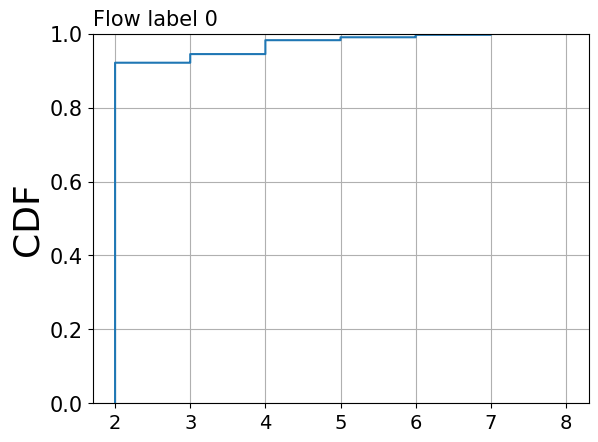

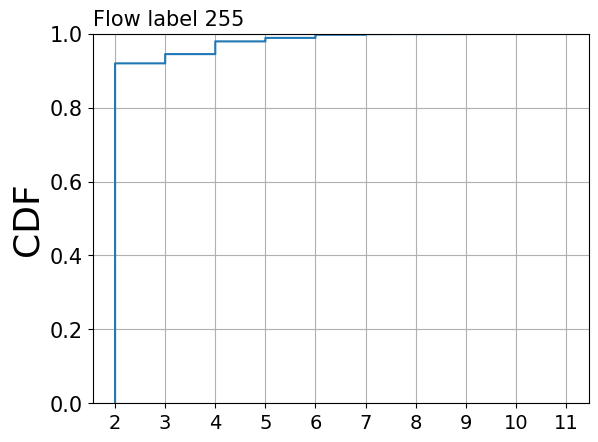

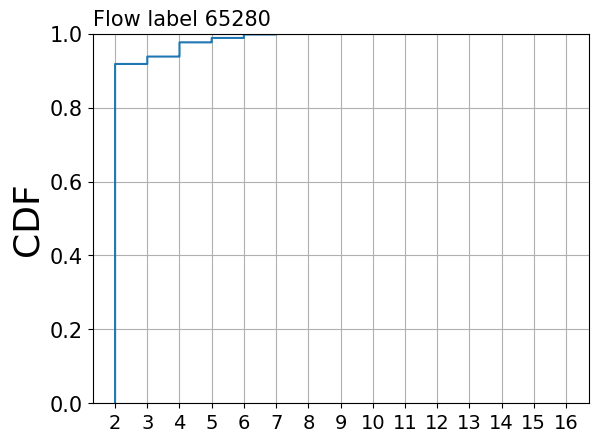

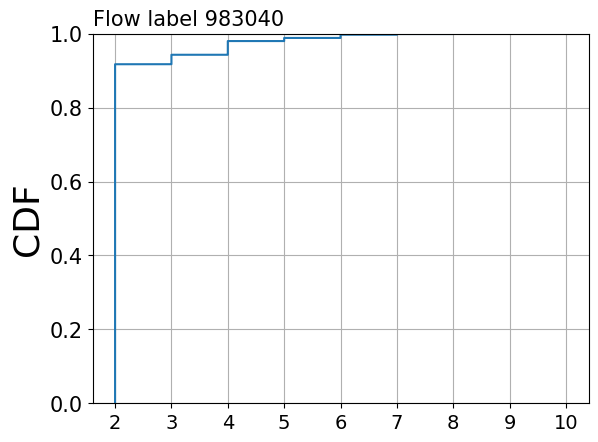

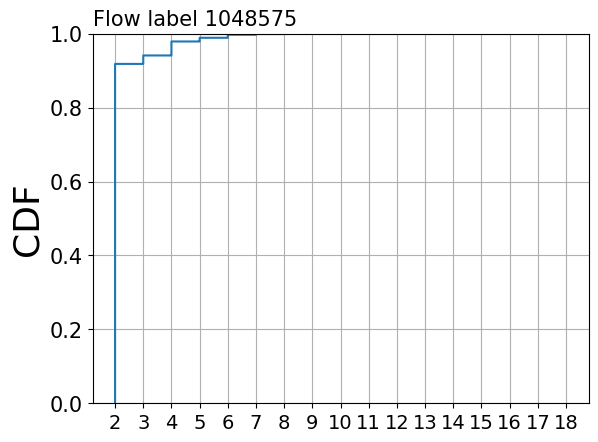

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_len_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_len_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

def get_divergence_hop_number(df: pd.DataFrame) -> str:
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        #hop_numbers = row[11].split()
        try:
            hop_numbers = [int(i) for i in row[11].split()]
        except ValueError:
            print("valueError")
            print(hop_numbers)
            return None
        zipped = list(zip(hop_ip_addresses, hop_numbers, strict=True))
        zipped_list.append(zipped)
        
    # If the zipped list is empty, return immediately
    if not zipped_list:
        return None
    
    longest_list: list = zipped_list[0]
    for i in zipped_list:
        if len(i) > len(longest_list):
            longest_list = i

    # Compare the items in the two lists and get the hop number
    shortest_list_len = get_len_of_shortest_list(zipped_list)
    for i in range(shortest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                return min(zipped_list[0][i][1], zipped_list[1][i][1])
        except IndexError:
            return longest_list[0][i][1]
    # If we got this far, the hops did not diverge
    return None

plt.rcdefaults()
FONTSIZE = 15
plt.rc('axes', titlesize=FONTSIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONTSIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=(FONTSIZE-1))    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONTSIZE)    # fontsize of the tick labels

for flow_label in FLOW_LABELS:
    divergence_data = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        divergence_data.append(
            get_divergence_hop_number(dst_df))
    # Create CDF Plot
    ndiv_count = divergence_data.count(None)
    #res = [int(i) for i in divergence_data if i != None]
    res = list()
    for i in divergence_data:
        if i != None:
            try:
                hop_num = int(i)
                res.append(hop_num)
            except ValueError:
                #print(f"valueError: {i}")
                pass
    sns.ecdfplot(data=res)
    plt.xticks(np.arange(min(res), max(res)+1, 1.0))
    plt.ylabel("CDF", fontsize=26)
    #plt.legend(title = "Flow label:")
    #plt.title(f"Vantage point {vantage_point}")
    plt.title(f"Flow label {flow_label}", loc = 'left')
    #plt.figtext(0.5, 0.01, f"Hop number where divergence occurred with flow label {flow_label}.", wrap=True, horizontalalignment='center', fontsize=12)
    plt.grid()
    plt.show()

## What are the IP-addresses of the load balancers we measured, and how many unique load balancers have we measured?
### Note: This is not a measurement of *all* load balancers, but it is a measurement of the number of load balancers we encounter when the first path divergence is detected.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_length_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

# If the paths diverge at the first hop, we return the unique
# hop IP(s) of the first hop(s).
# Erlend note: Maybe not correct, as the load balancer
# that caused the paths to diverge in this case is the
# load balancer with TTL=1
# The better thing to do would be to return the IP
# address of the default gateway.
def get_divergence_hop_ip(df: pd.DataFrame) -> str:
    """
    Compare two rows and get the hop IP where they diverge.
    """
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        hop_numbers = row[11].split()
        zipped = list(zip(hop_ip_addresses, hop_numbers, strict=True))
        zipped_list.append(zipped)

    # Compare the items in the two lists and get the load balancer IP
    longest_list_len = get_length_of_longest_list(zipped_list)
    for i in range(longest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                if i != 0:
                    # We are returning the previous IP (the last IP that was equal),
                    # as we are assuming that this is the load balancer that caused the
                    # paths to diverge.
                    min_current_hop_numbers = min(int(zipped_list[0][i][1]),int(zipped_list[1][i][1]))
                    previous_ip = zipped_list[0][i-1][0]
                    previous_hop_number = int(zipped_list[0][i-1][1])
                    if (min_current_hop_numbers - 1) == previous_hop_number:
                        return previous_ip
        except IndexError:
            # If we get an IndexError, it means that one of hop lists was longer than the other.
            # Because we can't assume that the previous hop actually was a load balancer (we need at least 2 
            # hops to compare against each other), we simply return None here, meaning that the comparison
            # is invalid.
            return None
    # If we got this far, the hops did not diverge
    return None

for flow_label in FLOW_LABELS:
    load_balancer_ips = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        load_balancer_ips.append(
            get_divergence_hop_ip(dst_df))
    load_balancers = [ip for ip in load_balancer_ips if ip != None]
    unique_lb = set(load_balancers)
    # Incrementing by 1 to account for TTL=2
    num_unique_lb = len(unique_lb) + 1
    print(f"Number of unique load balancers for flow label: {flow_label}:")
    print(num_unique_lb)

Number of unique load balancers for flow label: 0:
127
Number of unique load balancers for flow label: 255:
112
Number of unique load balancers for flow label: 65280:
116
Number of unique load balancers for flow label: 983040:
121
Number of unique load balancers for flow label: 1048575:
130


## How many unique paths do we have that diverge? Is there an overlap in the paths that diverge?
### It would be interesting to contrast the number of unique routers at which a path change happened with the number of unique paths that diverge, for each flow label.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    """
    Get the length of the longest list in list_of_lists
    """
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_paths_that_diverge(df: pd.DataFrame) -> list:
    """
    Get a list of all path hashes where a divergence was detected.
    """
    path_hashes = list()
    for row in df.itertuples():
        path_hash = str(row[8])
        path_hashes.append(path_hash)
        
    if path_hashes:
        try:
            if path_hashes[0] != path_hashes[1]:
                return path_hashes
        except IndexError:
            return None
    return None


for flow_label in FLOW_LABELS:
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    path_hashes = list()
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        path_hashes_that_diverge: list = get_paths_that_diverge(dst_df)
        if path_hashes_that_diverge:
            path_hashes.extend(path_hashes_that_diverge)
    path_hashes = [str(i) for i in path_hashes if i != None]
    unique_paths_that_diverge = set(path_hashes)
    len_unique_paths = len(unique_paths_that_diverge)
    print(f"Number of unique divergent paths for flow label: {flow_label}")
    print(f"{len_unique_paths=}")

Number of unique divergent paths for flow label: 0
len_unique_paths=14117
Number of unique divergent paths for flow label: 255
len_unique_paths=13900
Number of unique divergent paths for flow label: 65280
len_unique_paths=13727
Number of unique divergent paths for flow label: 983040
len_unique_paths=13505
Number of unique divergent paths for flow label: 1048575
len_unique_paths=13465


# the *total* number of unique routers where paths have diverged

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#df: pd.DataFrame = sq.load_single(db_path)

def get_unique_destination_addresses(df: pd.DataFrame) -> list:
    """
    Get all unique values in the DESTINATION_IP column.
    """
    return df["DESTINATION_IP"].unique().tolist()

def get_length_of_longest_list(list_of_lists: list) -> int:
    # Get the length of the longest list in list_of_lists
    longest_list_len = 0
    for lst in list_of_lists:
        if len(lst) > longest_list_len:
            longest_list_len = len(lst)
    return longest_list_len

def get_length_of_shortest_list(list_of_lists: list) -> int:
    # Get the length of the shortest list in list_of_lists
    shortest_list_len = len(list_of_lists[0])
    for lst in list_of_lists:
        if len(lst) < shortest_list_len:
            shortest_list_len = len(lst)
    return shortest_list_len

# If the paths diverge at the first hop, we return the unique
# hop IP(s) of the first hop(s).
# Erlend note: Maybe not correct, as the load balancer
# that caused the paths to diverge in this case is the
# load balancer with TTL=1
# The better thing to do would be to return the IP
# address of the default gateway.
def get_divergence_hop_ip(df: pd.DataFrame) -> str:
    """
    Compare two rows and get the hop IP where they diverge.
    """
    # Setup: creating the combined columns, represented as a list of tuples
    zipped_list = list()
    for row in dst_df.itertuples():
        hop_ip_addresses = row[10].split()
        hop_numbers = row[11].split()
        hop_asns = row[13].split()
        zipped = list(zip(hop_ip_addresses, hop_numbers, hop_asns, strict=True))
        zipped_list.append(zipped)

    # Compare the items in the two lists and get the load balancer IP
    longest_list_len = get_length_of_longest_list(zipped_list)
    for i in range(longest_list_len):
        try:
            if zipped_list[0][i] != zipped_list[1][i]:
                if i != 0:
                    # We are returning the previous IP (the last IP that was equal),
                    # as we are assuming that this is the load balancer that caused the
                    # paths to diverge.
                    min_current_hop_numbers = min(int(zipped_list[0][i][1]),int(zipped_list[1][i][1]))
                    previous_ip = zipped_list[0][i-1][0]
                    previous_hop_number = int(zipped_list[0][i-1][1])
                    previous_hop_asn = str(zipped_list[0][i-1][2])
                    if (min_current_hop_numbers - 1) == previous_hop_number:
                        return (previous_ip, previous_hop_asn)
        except IndexError:
            # If we get an IndexError, it means that one of hop lists was longer than the other.
            # Because we can't assume that the previous hop actually was a load balancer (we need at least 2 
            # hops to compare against each other), we simply return None here, meaning that the comparison
            # is invalid.
            return None
    # If we got this far, the hops did not diverge
    return None

routers = list()
asns = list()
combined = list()
for flow_label in FLOW_LABELS:
    load_balancers = list()
    tuple_asns = list()
    unique_destination_addresses: list = get_unique_destination_addresses(df)
    for dst in unique_destination_addresses:
        dst_df = df[(df["SOURCE_FLOW_LABEL"] == flow_label)
                    & (df["DESTINATION_IP"] == dst)]
        divergence_hop_tuple: tuple = get_divergence_hop_ip(dst_df)
        if divergence_hop_tuple is not None:
            load_balancers.append(divergence_hop_tuple[0])
            tuple_asns.append(divergence_hop_tuple[1])
    routers.extend(load_balancers)
    asns.extend(tuple_asns)

# The total number of unique routers where paths have diverged:
# NB. Does not include TTL=2 or paths with missing data (easier to explain with figure)

# Find the ASN distribution
combined = zip(routers, asns)
unique = set(combined)
asns = list()
print(f"Total number of unique load balancers where paths have diverged: {len(unique)}")
for i in unique:
    asns.append(i[1])

#np_routers = np.array(routers)
#unique_routers = np.unique(np_routers)
# NB. Consider perhaps incrementing by 1 to account for TTL=2
#num_unique_lb = unique_routers.size
#print(f"Number of unique load balancers for vantage point {vantage_point}:")
#print(num_unique_lb)

print(f"ASN distribution of the load balancers")
asn_series = pd.Series(asns)
asn_vc = asn_series.value_counts()
print(f"Value count:\n{asn_vc}")

#fig, ax = plt.subplots()
#ax.pie(asn_vc, labels=labels)
#ax.set_title('ASN distribution of the load balancers')
#plt.tight_layout()
#plt.show()

Total number of unique load balancers where paths have diverged: 307
ASN distribution of the load balancers
Value count:
1299     60
NULL     57
3356     40
2914     16
6453      8
         ..
34927     1
7303      1
8551      1
2519      1
12189     1
Length: 78, dtype: int64


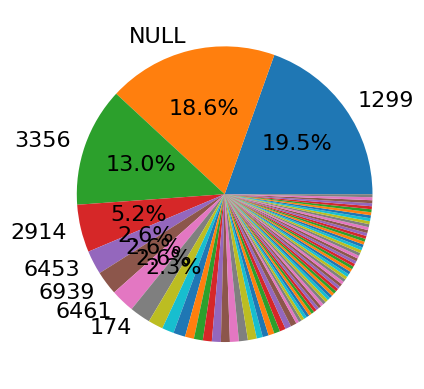

In [16]:
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(asn_vc, labels=asn_vc.index, autopct='%1.1f%%', textprops={'fontsize': 16})
#plt.title("ASN distribution of detected load balancers")
#ax.legend(bbox_to_anchor=(1.2, 1))

threshold = 2 
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')

# AS mapping of these 50’ish routers per vantage point. tell us as much as you can about them!

## Erlend note: Might be interesting to combine this with hop number data?
## E.g.: The traces that diverged at TTL=2 all belong to ASN 3000 

In [17]:
!whois 'AS3356'


#
# ARIN WHOIS data and services are subject to the Terms of Use
# available at: https://www.arin.net/resources/registry/whois/tou/
#
# If you see inaccuracies in the results, please report at
# https://www.arin.net/resources/registry/whois/inaccuracy_reporting/
#
# Copyright 1997-2023, American Registry for Internet Numbers, Ltd.
#


ASNumber:       3356
ASName:         LEVEL3
ASHandle:       AS3356
RegDate:        2000-03-10
Updated:        2018-02-20    
Ref:            https://rdap.arin.net/registry/autnum/3356


OrgName:        Level 3 Parent, LLC
OrgId:          LPL-141
Address:        100 CenturyLink Drive
City:           Monroe
StateProv:      LA
PostalCode:     71203
Country:        US
RegDate:        2018-02-06
Updated:        2023-04-07
Comment:        USAGE OF IP SPACE MUST COMPLY WITH OUR ACCEPTABLE USE POLICY:
Comment:        https://www.lumen.com/en-us/about/legal/acceptable-use-policy.html
Comment:        
Comment:        ADDRESSES COVERED BY THIS ORG-ID ARE NON-PORTAB

In [18]:
import whois

#w = whois.whois('2a00:1450:400f:801::200e')
w = whois.whois('AS3356')
print(w.expiration_date)
print(w.text)
print(w)

None

{
  "domain_name": null,
  "registrar": null,
  "whois_server": null,
  "referral_url": null,
  "updated_date": null,
  "creation_date": null,
  "expiration_date": null,
  "name_servers": null,
  "status": null,
  "emails": null,
  "dnssec": null,
  "name": null,
  "org": null,
  "address": null,
  "city": null,
  "state": null,
  "registrant_postal_code": null,
  "country": null
}
